In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

spark = SparkSession.builder.appName('RandomForestKFold').getOrCreate()


path = './data/treino_sinais_vitais_com_label.csv'
data = spark.read.csv(path, header=True, inferSchema=True)

input_cols = ["pSist", "pDiast", "qPa", "pulso", "respiracao"]
output_col = "rotulo"

indexer = StringIndexer(inputCol="rotulo", outputCol="label")
data = indexer.fit(data).transform(data)

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
data = assembler.transform(data)

rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

paramGrid = ParamGridBuilder().build()

crossval = CrossValidator(estimator=rf,
                          evaluator=evaluator,
                          estimatorParamMaps=paramGrid,
                          numFolds=5)

cv_model = crossval.fit(data)

best_model = cv_model.bestModel

predictions = best_model.transform(data)

accuracy = evaluator.evaluate(predictions)

print(f"Precisão do modelo após K-Fold Cross-Validation: {accuracy:.4f}")

predictions.select("features", "label", "prediction").show(10)


Precisão do modelo após K-Fold Cross-Validation: 0.8587
+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[13.592433,12.220...|  0.0|       0.0|
|[15.775386,13.586...|  0.0|       0.0|
|[3.649369,1.90480...|  1.0|       0.0|
|[17.264362,13.700...|  0.0|       0.0|
|[12.705183,9.4853...|  1.0|       1.0|
|[7.573969,1.46310...|  2.0|       0.0|
|[11.749524,4.1774...|  0.0|       0.0|
|[9.847899,8.20322...|  1.0|       1.0|
|[18.143625,14.362...|  0.0|       0.0|
|[19.790224,14.473...|  2.0|       2.0|
+--------------------+-----+----------+
only showing top 10 rows



24/12/10 18:00:39 WARN DAGScheduler: Broadcasting large task binary with size 1192.3 KiB
24/12/10 18:00:39 WARN DAGScheduler: Broadcasting large task binary with size 1501.9 KiB
24/12/10 18:00:39 WARN DAGScheduler: Broadcasting large task binary with size 1732.8 KiB
24/12/10 18:00:40 WARN DAGScheduler: Broadcasting large task binary with size 1238.9 KiB
24/12/10 18:00:42 WARN DAGScheduler: Broadcasting large task binary with size 1201.4 KiB
24/12/10 18:00:42 WARN DAGScheduler: Broadcasting large task binary with size 1523.9 KiB
24/12/10 18:00:42 WARN DAGScheduler: Broadcasting large task binary with size 1761.8 KiB
24/12/10 18:00:43 WARN DAGScheduler: Broadcasting large task binary with size 1262.0 KiB
24/12/10 18:00:44 WARN DAGScheduler: Broadcasting large task binary with size 1185.7 KiB
24/12/10 18:00:45 WARN DAGScheduler: Broadcasting large task binary with size 1494.0 KiB
24/12/10 18:00:45 WARN DAGScheduler: Broadcasting large task binary with size 1723.3 KiB
24/12/10 18:00:45 WAR

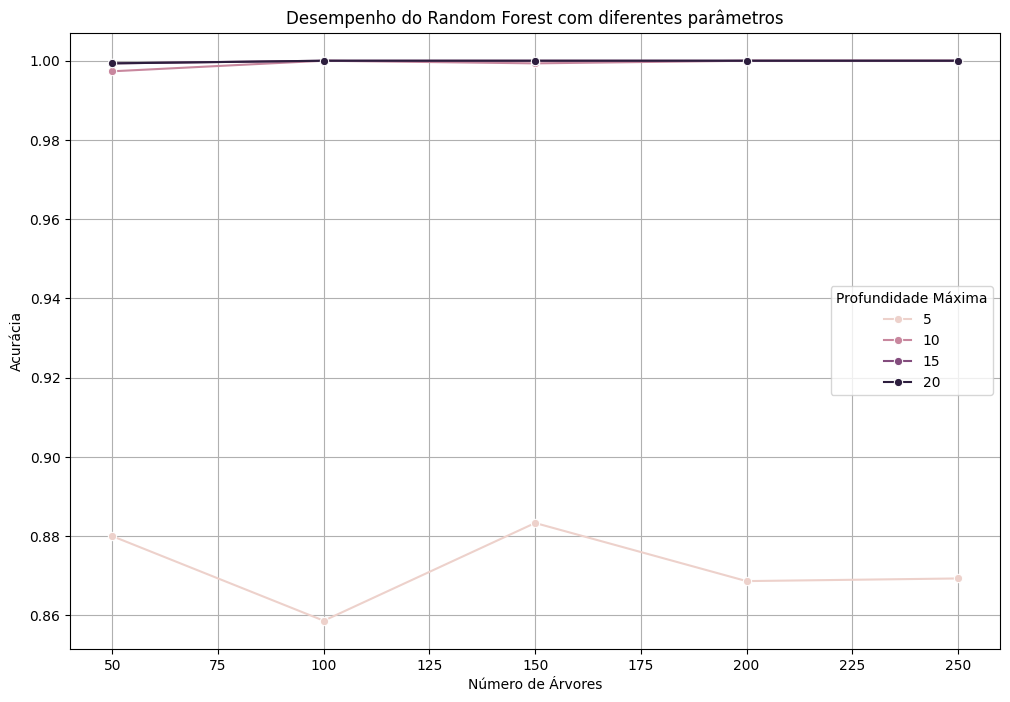

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Inicialização do Spark
spark = SparkSession.builder.appName('RandomForestKFold').getOrCreate()

# Carregar os dados
path = './data/treino_sinais_vitais_com_label.csv'
data = spark.read.csv(path, header=True, inferSchema=True)

# Definir as colunas de entrada e saída
input_cols = ["pSist", "pDiast", "qPa", "pulso", "respiracao"]
output_col = "rotulo"

# Transformar a coluna de rótulo em números
indexer = StringIndexer(inputCol="rotulo", outputCol="label")
data = indexer.fit(data).transform(data)

# Criar a coluna de características
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
data = assembler.transform(data)

# Definir o classificador Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

# Definir o avaliador
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Definir os valores para o número de árvores e profundidade máxima
trees_list = [50, 100, 150, 200, 250]
depth_list = [5, 10, 15, 20]

results = []

# Testar combinações de número de árvores e profundidade máxima
for trees in trees_list:
    for depth in depth_list:
        paramGrid = ParamGridBuilder() \
            .addGrid(rf.numTrees, [trees]) \
            .addGrid(rf.maxDepth, [depth]) \
            .build()

        # Criar o CrossValidator para cada combinação
        crossval = CrossValidator(estimator=rf,
                                  evaluator=evaluator,
                                  estimatorParamMaps=paramGrid,
                                  numFolds=5)

        # Treinar o modelo com K-Fold Cross-Validation
        cv_model = crossval.fit(data)

        # Obter as previsões e calcular a precisão
        predictions = cv_model.bestModel.transform(data)
        accuracy = evaluator.evaluate(predictions)

        # Registrar os resultados
        results.append({"numTrees": trees, "maxDepth": depth, "accuracy": accuracy})

# Criar um DataFrame com os resultados
results_df = pd.DataFrame(results)

# Visualizar os resultados com gráficos
plt.figure(figsize=(12, 8))
sns.lineplot(data=results_df, x="numTrees", y="accuracy", hue="maxDepth", marker="o")
plt.title("Desempenho do Random Forest com diferentes parâmetros")
plt.xlabel("Número de Árvores")
plt.ylabel("Acurácia")
plt.legend(title="Profundidade Máxima")
plt.grid(True)
plt.show()


In [6]:
# Criar um DataFrame com os resultados
results_df = pd.DataFrame(results)


# print best result of accuracy and its parameters

best_result = results_df.loc[results_df['accuracy'].idxmax()]

print(f"Melhor resultado de precisão: {best_result['accuracy']:.4f}")
print(f"Número de árvores: {best_result['numTrees']}")
print(f"Profundidade máxima: {best_result['maxDepth']}")


Melhor resultado de precisão: 1.0000
Número de árvores: 100.0
Profundidade máxima: 10.0
